## Loading Data

In [2]:
#Tokenizer

import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset
import numpy as np
from torchtext.data.utils import get_tokenizer
import random
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import dill

spacy_en = spacy.load('en')


def tokenize_en(text, max_length=100):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)][:max_length-2]


SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

tv_datafields = [("id", None),("src", SRC),("trg", TRG)]
td_datafields = [("id", None),("src", SRC), ("trg", TRG)]
print("Loading Datasets")
train_txt, val_txt = TabularDataset.splits(
               path="cured_data", # the root directory where the data lies
               train='train.csv', validation="val.csv",
               format='csv',
               skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
               fields=tv_datafields)

test_txt = TabularDataset(
           path="cured_data/test.csv", # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=td_datafields)
print("Loaded Datasets")
SRC.build_vocab(train_txt)
TRG.build_vocab(train_txt)

""" with open("model/SRC.Field","wb")as f:
     dill.dump(SRC,f)
with open("model/TRG.Field","wb")as f:
     dill.dump(TRG,f)
with open("model/test.DS","wb")as f:
     dill.dump(test_txt,f)
with open("model/train.DS","wb")as f:
     dill.dump(train_txt,f)
with open("model/val.DS","wb")as f:
     dill.dump(val_txt,f)


with open("model/SRC.Field","rb")as f:
     SRC=dill.load(f)
with open("model/TRG.Field","rb")as f:
     TRG=dill.load(f)
with open("model/train.DS","rb")as f:
     train_txt=dill.load(f)
with open("model/val.DS","rb")as f:
     val_txt=dill.load(f)
with open("model/test.DS","rb")as f:
     test_txt=dill.load(f) """
          
SRC.build_vocab(train_txt)
TRG.build_vocab(train_txt)
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("Starting vocabulary building")
SRC.build_vocab(train_txt, min_freq = 2)
TRG.build_vocab(train_txt, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loading Datasets
Loaded Datasets
Starting vocabulary building


### Preparing Iterator

In [3]:
BATCH_SIZE = 128
print("Starting iterator")
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_txt, val_txt, test_txt), 
     batch_size = BATCH_SIZE,
     sort=False,
     device = device)

Starting iterator


### Encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length =100
                 ):
        super().__init__()

        self.device = device
        print("Before embedding")
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        print("After embedding")
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        #print(src.shape)
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

#### Encoder Layer

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### MultiHeadAttentionLayer

In [6]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### PositionwiseFeedforwardLayer

In [7]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

#### Decoder Layer

In [9]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq Module

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Preparation

In [11]:
print(len(SRC.vocab))
INPUT_DIM = len(SRC.vocab)
print(len(TRG.vocab))
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

LEARNING_RATE = 0.0005
print("Creating optimizer")
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
print("Establishing criterion")
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

43729
13424
Before embedding
After embedding
The model has 22,086,000 trainable parameters
Creating optimizer
Establishing criterion


# Training

In [12]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        #print(src)
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Evaluate

In [13]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


## Epoch Time

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Actual Training

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print("We are here")
    start_time = time.time()
    print("We are here, right before training")
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    print("Training done, time to validate")
    valid_loss = evaluate(model, valid_iterator, criterion)
    print("Validation done")
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


We are here
We are here, right before training


## Translate Sentences

In [21]:
def parse_target(predicted_trg):
    predicted_trg = "".join(predicted_trg)
    predicted_trg = predicted_trg.replace("<unk>","")
    predicted_trg = predicted_trg.replace("<eos>","")
    predicted_trg = predicted_trg.replace("[","")
    predicted_trg = predicted_trg.replace("]","")
    predicted_trg = predicted_trg.replace("'","")
    predicted_trg = predicted_trg.split(",")
    predicted_trg = list(filter(None, predicted_trg))
    return predicted_trg
    
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 100):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

## Display Attention

In [22]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

# Testing the Thing
## Good Examples

src = ['si', 'bien', 'vivimos', 'en', 'una', 'sociedad', 'global', ',', 'los', 'educadores', 'se', 'enfrentan', 'a', 'numerosos', 'desafíos', 'a', 'la', 'hora', 'de', 'hallar', 'formas', 'significativas', '\n', 'de', 'conectar', 'a', 'los', 'alumnos', 'con', 'gente', 'de', 'otras', 'culturas', '.', 'este', 'artículo', 'muestra', 'un', 'caso', 'práctico', 'de', 'colaboración', 'entre', 'profesores', '\n', 'de', 'los', 'estados', 'unidos', 'y', 'turquía', ',', 'en', 'el', 'que', 'alumnos', 'de', 'séptimo', 'grado', 'interactuaron', 'entre', 'sí', 'a', 'través', 'de', 'las', 'redes', 'sociales', 'con', 'el', '\n', 'fin', 'de', 'promover', 'la', 'comprensión', 'cultural', '.', 'al', 'analizar', 'una', 'única', 'actividad', 'de', 'aprendizaje', 'hallamos', 'que', 'los', 'alumnos', 'tenían', 'la', 'oportunidad', '\n', 'de', 'compartir', 'ideas', 'informalmente', 'a']
trg = ['mediadigitales', 'mediossociales', 'middleschool', 'popularculture', 'cross-cultural', 'digitalmedia', 'socialmedia', 

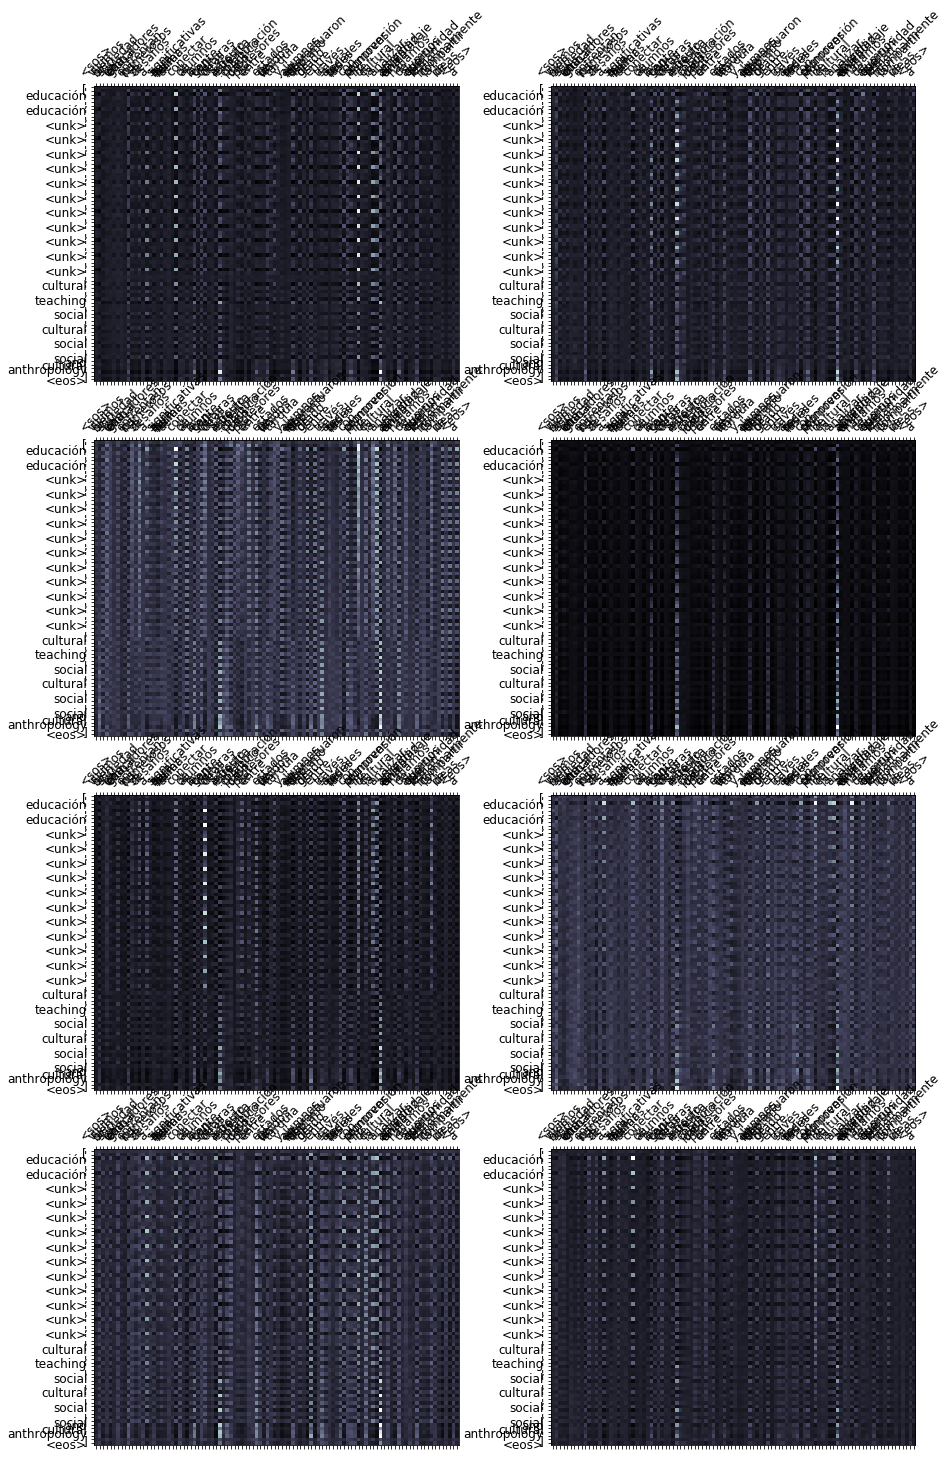

src = ['order', 'statistics', 'and', 'linear', 'functions', 'of', 'order', 'statistics', 'are', 'frequently', 'used', 'as', 'estimators', 'of', 'location', 'and', 'scale', '.', 'the', 'moments', 'of', 'order', 'statistics', 'have', 'been', 'tabled', 'for', 'many', 'commonly', 'used', 'distributions', 'under', 'assumptions', 'of', 'independence', 'and', 'identical', 'distribution', '.', 'applications', 'of', 'estimators', 'based', 'on', 'the', 'order', 'statistics', 'have', 'spread', 'to', 'situations', 'in', 'which', 'identical', 'distribution', 'can', 'not', 'be', 'assumed', ',', 'even', 'though', 'independence', 'is', 'still', 'a', 'sensible', 'assumption', '.', 'as', 'an', 'example', ',', 'estimators', 'based', 'on', 'order', 'statistics', 'are', 'used', 'in', 'the', 'field', 'of', 'communications', 'where', 'the', 'median', 'and', 'other', 'functions', 'of', 'order', 'statistics', 'of', 'a', 'moving', 'sample']
trg = ['statistics', 'statisticsandprobability']
predicted trg = ['stat

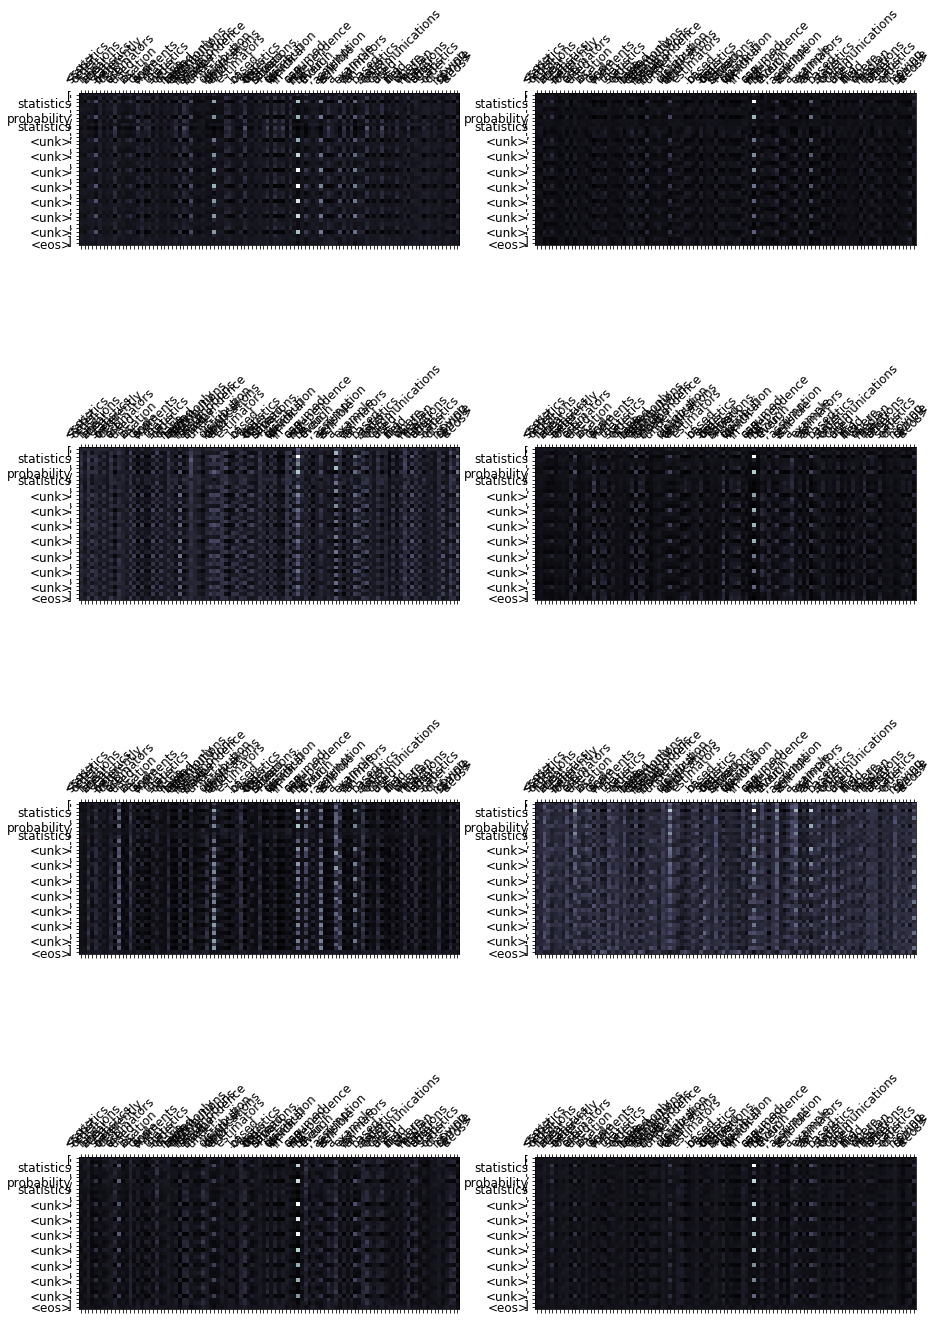

src = ['in', 'this', 'paper', 'we', 'propose', 'a', 'new', 'supersymmetric', 'extension', 'of', 'conformal', 'mechanics', '.', 'the', 'grassmannian', 'variables', 'that', 'we', 'introduce', 'are', 'the', 'basis', 'of', 'the', 'forms', 'and', 'of', 'the', 'vector', '-', 'fields', 'built', 'over', 'the', 'symplectic', 'space', 'of', 'the', 'original', 'system', '.', 'our', 'supersymmetric', 'hamiltonian', 'itself', 'turns', 'out', 'to', 'have', 'a', 'clear', 'geometrical', 'meaning', 'being', 'the', 'lie', '-', 'derivative', 'of', 'the', 'hamiltonian', 'flow', 'of', 'conformal', 'mechanics', '.', 'using', 'superfields', 'we', 'derive', 'a', 'constraint', 'which', 'gives', 'the', 'exact', 'solution', 'of', 'the', 'supersymmetric', 'system', 'in', 'a', 'way', 'analogous', 'to', 'the', 'constraint', 'in', 'configuration', 'space', 'which', 'solved', 'the', 'original', 'non', '-', 'supersymmetric']
trg = ['particlephysics-theory']
predicted trg = ['particlephysics-theory']


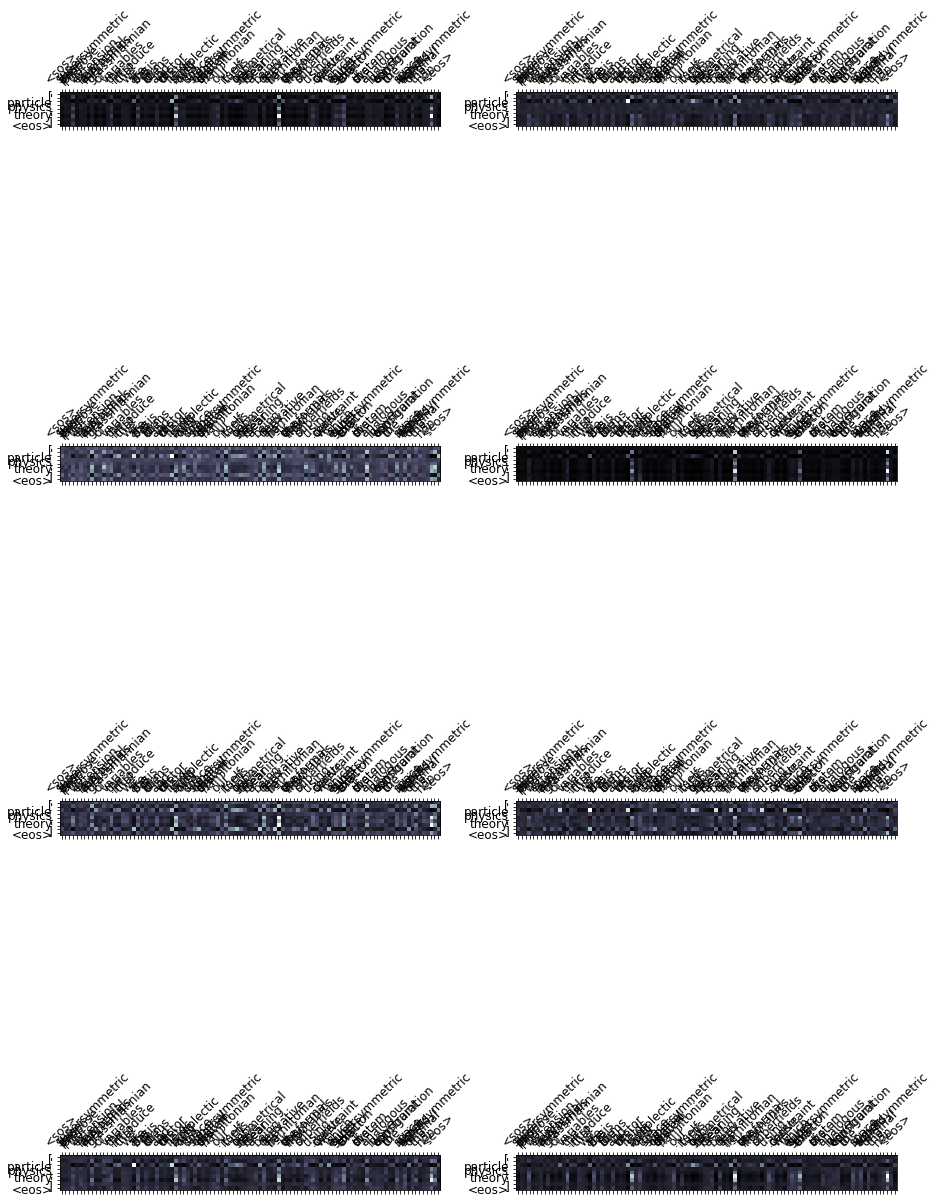

In [23]:
model.load_state_dict(torch.load('transformer_model.pt'))
example_idx = 150

src = vars(train_txt.examples[example_idx])['src']
trg = vars(train_txt.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {parse_target(trg)}')

translation1, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {parse_target(translation1)}')

display_attention(src, translation1, attention)

example_idx = 310

src = vars(val_txt.examples[example_idx])['src']
trg = vars(val_txt.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {parse_target(trg)}')

translation2, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {parse_target(translation2)}')
display_attention(src, translation2, attention)

example_idx = 44

src = vars(test_txt.examples[example_idx])['src']
trg = vars(test_txt.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {parse_target(trg)}')

translation3, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {parse_target(translation3)}')

display_attention(src, translation3, attention)



## Bad examples

src = ['scopo', 'di', 'questo', 'testo', 'è', 'presentare', 'l’attività', 'di', 'named', 'entity', 'extraction', ',', 'focalizzando', 'l’attenzione', 'sull’approccio', 'machine', 'learning', 'e', 'sulle', 'tecniche', 'implementate', 'nella', 'piattaforma', 'gate', '/', 'annie', '.', 'è', 'dapprima', 'fornita', 'una', 'panoramica', 'del', 'settore', 'natural', 'language', 'processing', ',', 'analizzandone', 'le', 'radici', 'storiche', ',', 'le', 'problematiche', 'principali', 'e', 'la', 'complessità', 'dovuta', 'all’ambiguità', 'del', 'linguaggio', 'umano', '.', 'successivamente', 'è', 'approfondito', 'il', 'task', 'di', 'information', 'extraction', ',', 'all’interno', 'del', 'quale', 'si', 'inserisce', 'proprio', 'l’attività', 'di', 'named', 'entity', 'extraction', '.', 'si', 'introduce', 'quindi', 'il', 'tema', 'machine', 'learning', ',', 'presentato', 'prima', 'in', 'una', 'visione', 'più', 'generale', 'e', 'poi', 'inserito', 'nel', 'settore', 'natural', 'language']
trg = ['naturalla

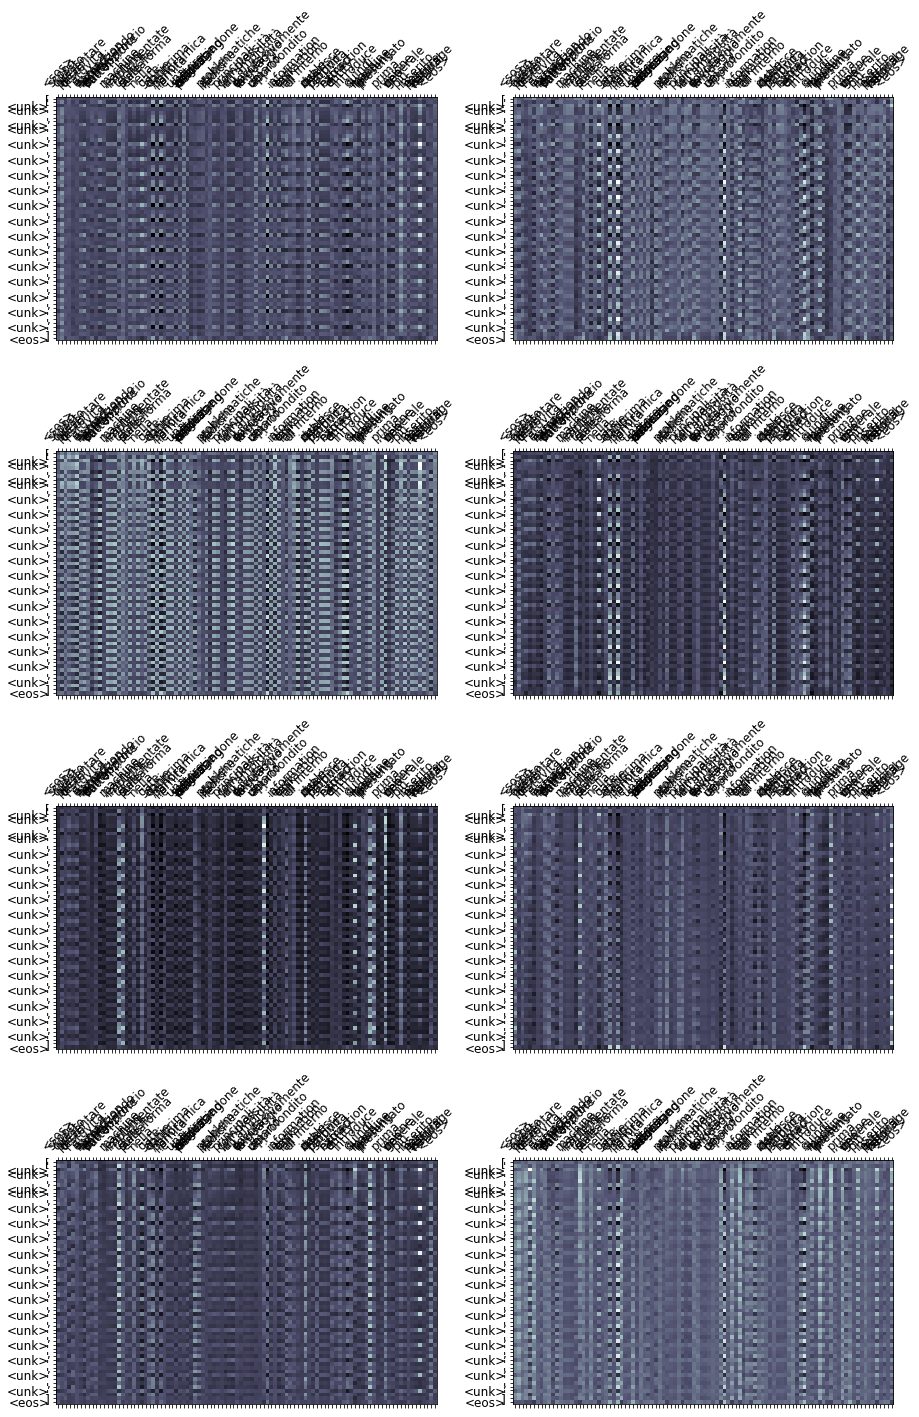

src = ['this', 'paper', 'deals', 'with', 'the', 'possible', 'benefits', 'of', 'perceptual', 'learning', 'in', 'artificial', 'intelligence', '.', 'on', 'the', 'one', 'hand', ',', 'perceptual', 'learning', 'is', 'more', 'and', 'more', 'studied', 'in', 'neurobiology', 'and', 'is', 'now', 'considered', 'as', 'an', 'essential', 'part', 'of', 'any', 'living', 'system', '.', 'in', 'fact', ',', 'perceptual', 'learning', 'and', 'cognitive', 'learning', 'are', 'both', 'necessary', 'for', 'learning', 'and', 'often', 'depends', 'on', 'each', 'other', '.', 'on', 'the', 'other', 'hand', ',', 'many', 'works', 'in', 'machine', 'learning', 'are', 'concerned', 'with', '"', 'abstraction', '"', 'in', 'order', 'to', 'reduce', 'the', 'amount', 'of', 'complexity', 'related', 'to', 'some', 'learning', 'tasks', '.', 'in', 'the', 'abstraction', 'framework', ',', 'perceptual', 'learning']
trg = ['artificialvision', 'reformulation', 'abstraction', 'machinelearning', 'autonomousrobotics', 'artificialvision.', 'inf

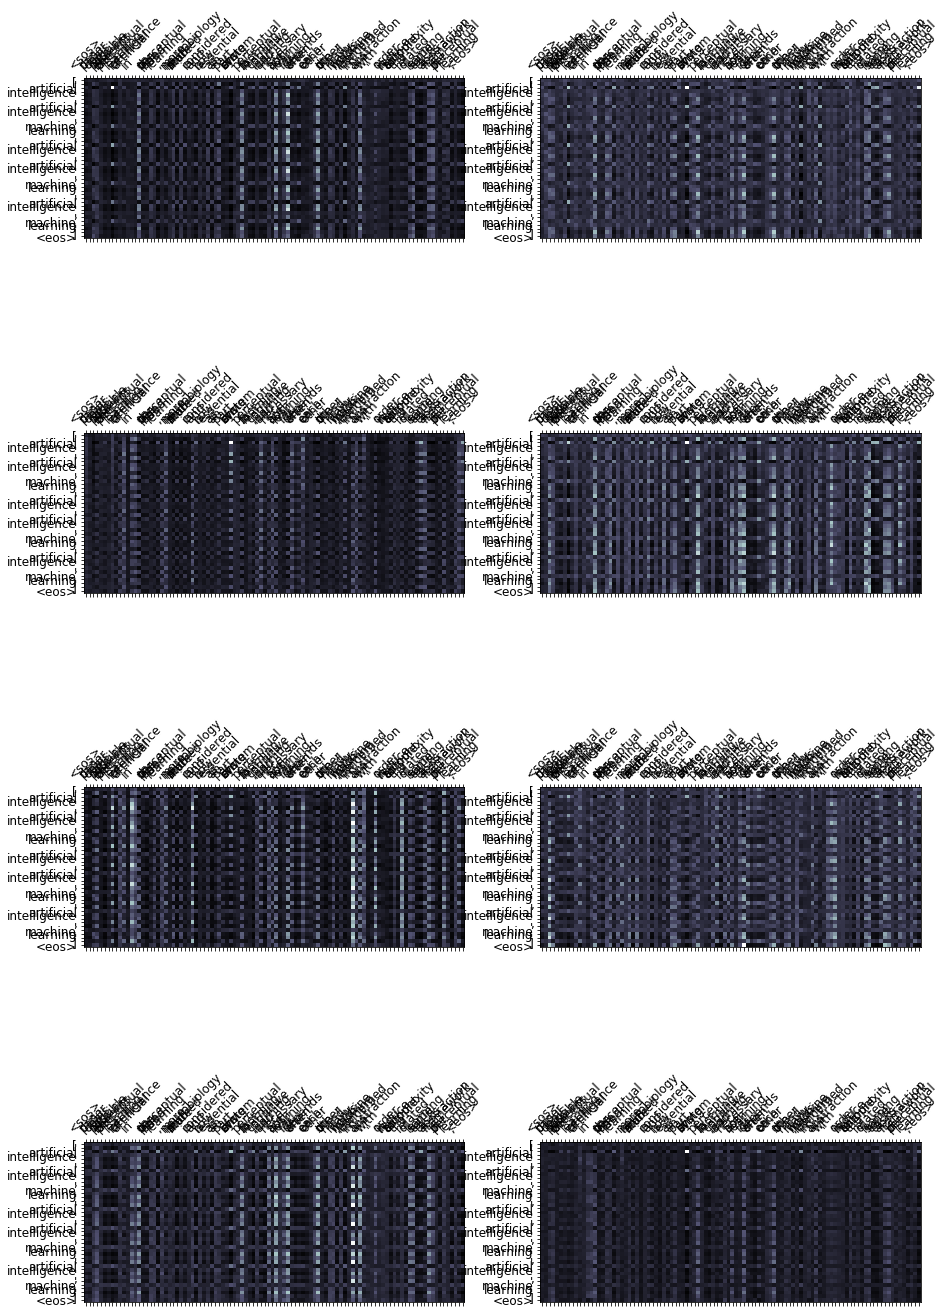

src = ['background', ':', 'the', 'shortage', 'of', 'medical', 'providers', 'in', 'rural', 'areas', 'is', 'one', 'of', 'the', 'greatest', 'barriers', 'to', 'accessing', 'healthcare', 'in', 'the', 'united', 'states', '.', 'mental', 'healthcare', 'providers', 'are', 'especially', 'limited', 'in', 'numbers', 'and', 'availability', 'in', 'rural', 'areas', '.', 'although', 'all', 'individuals', 'living', 'rurally', 'have', 'challenges', 'with', 'receiving', 'care', ',', 'one', 'group', 'that', 'demonstrates', 'an', 'exceptional', 'deficiency', 'with', 'access', 'to', 'care', 'is', 'veterans', '.', 'the', 'numbers', 'of', 'veterans', 'living', 'rurally', 'are', 'significantly', 'higher', 'than', 'vets', 'living', 'close', 'to', 'urban', 'or', 'suburban', 'centers', 'of', 'care', '.', 'considering', 'the', 'shortages', 'of', 'mental', 'health', 'providers', ',', 'alternatives', 'to', 'traditional', 'in', '-', 'person']
trg = ['mentalhealth', 'telemedicine', 'videoteleconferencing', 'veterans',

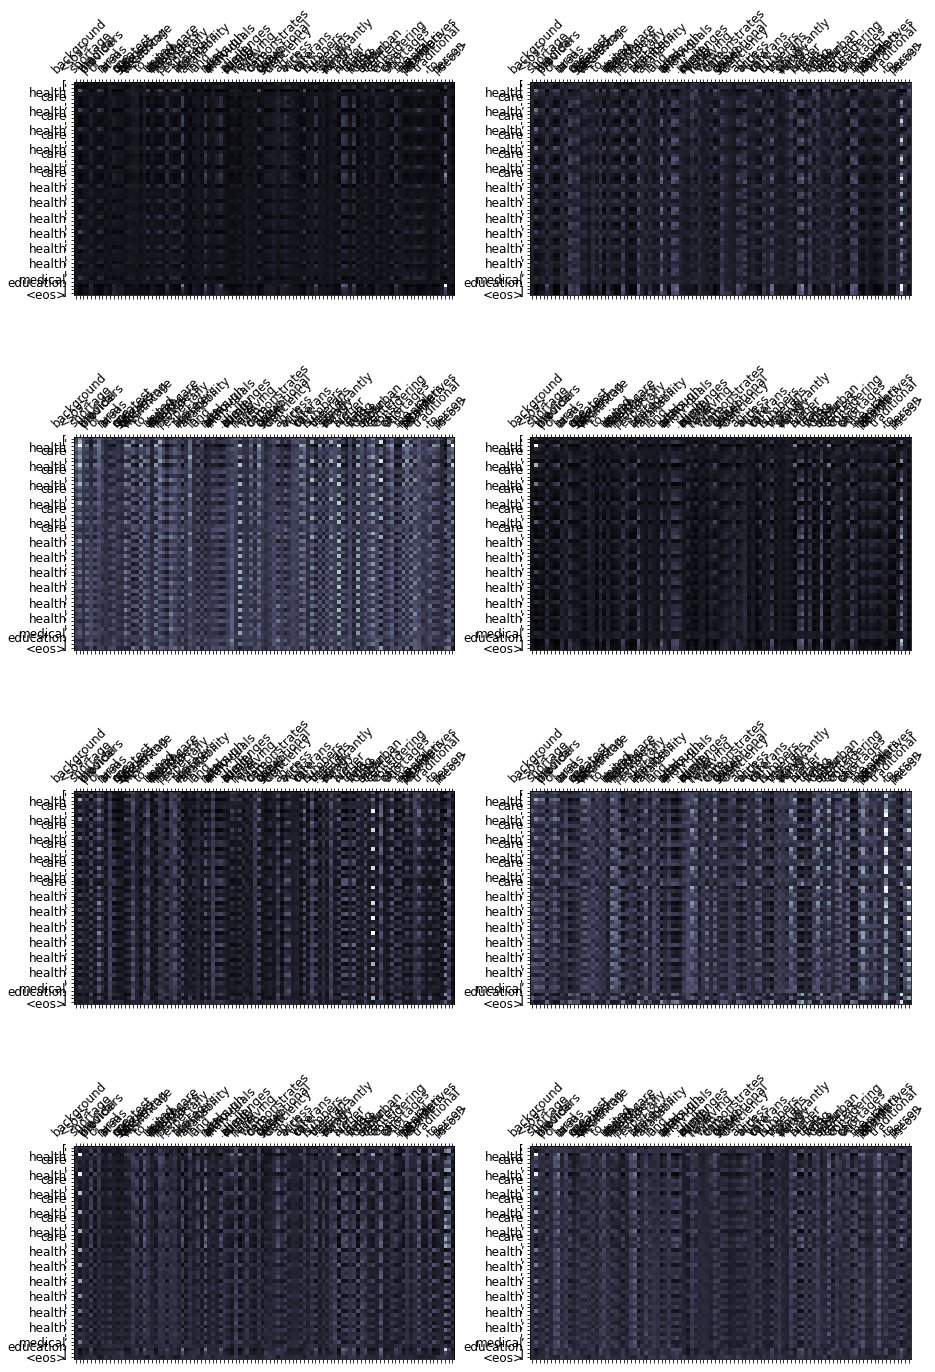

In [24]:
example_idx = 8

src = vars(test_txt.examples[example_idx])['src']
trg = vars(test_txt.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {parse_target(trg)}')

translation3, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {parse_target(translation3)}')

display_attention(src, translation3, attention)

example_idx = 196

src = vars(test_txt.examples[example_idx])['src']
trg = vars(test_txt.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {parse_target(trg)}')

translation3, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {parse_target(translation3)}')

display_attention(src, translation3, attention)

example_idx = 666

src = vars(test_txt.examples[example_idx])['src']
trg = vars(test_txt.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {parse_target(trg)}')

translation3, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {parse_target(translation3)}')

display_attention(src, translation3, attention)

## Bleu Score

In [25]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 100):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

bleu_score = calculate_bleu(test_txt, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

IndexError: index 4 is out of bounds for dimension 0 with size 4

In [26]:
test_loss = evaluate(model, test_iterator, criterion)

In [27]:
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.888 | Test PPL:   6.604 |
